In [7]:
# -------------------------------------------------
# 1️⃣  Libraries
# -------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# Plot style
sns.set(style='whitegrid', palette='muted', font_scale=1.1)
%matplotlib inline


In [8]:
# -------------------------------------------------
# 2️⃣  Load train & test
# -------------------------------------------------
train_path = 'train.csv'          # <- copy the file content from the prompt
test_path  = 'test.csv'          # <- copy the file content from the prompt

# The CSVs contain quoted fields with commas → use the Python engine
train = pd.read_csv(train_path, engine='python')
test  = pd.read_csv(test_path , engine='python')

# Quick sanity‑check
print(train.shape, test.shape)          # (891, 12)  (418, 11)
print(train.head())


(891, 12) (418, 11)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500

In [9]:
# -------------------------------------------------
# 3️⃣  Combine for preprocessing
# -------------------------------------------------
train['Dataset'] = 'train'
test['Dataset']   = 'test'
test['Survived'] = np.nan          # placeholder – needed for the concat

full = pd.concat([train, test], axis=0, sort=False, ignore_index=True)
print(full.shape)                  # (1309, 13) – 891+418 rows


(1309, 13)


In [10]:
# -------------------------------------------------
# 4️⃣  Missing‑value overview
# -------------------------------------------------
miss = full.isnull().sum().sort_values(ascending=False)
miss_percentage = (miss / len(full) * 100).round(2)
missing_df = pd.concat([miss, miss_percentage], axis=1, keys=['Count', 'Percent'])
print(missing_df)


             Count  Percent
Cabin         1014    77.46
Survived       418    31.93
Age            263    20.09
Embarked         2     0.15
Fare             1     0.08
Sex              0     0.00
Name             0     0.00
Pclass           0     0.00
PassengerId      0     0.00
Ticket           0     0.00
Parch            0     0.00
SibSp            0     0.00
Dataset          0     0.00


In [11]:
most_common_emb = full['Embarked'].mode()[0]   # 'S'
full['Embarked'].fillna(most_common_emb, inplace=True)


In [12]:
full['Fare'].fillna(full['Fare'].median(), inplace=True)


In [13]:
def get_deck(cabin):
    if pd.isna(cabin):
        return np.nan
    return cabin.split()[0][0]   # first character of first cabin entry

full['Deck'] = full['Cabin'].apply(get_deck)
full['Deck'].fillna('U', inplace=True)           # U = unknown


In [14]:
def ticket_prefix(t):
    # remove spaces, keep leading letters or numeric part
    t = str(t).replace('.', '').replace('/', ' ').strip()
    prefix = t.split()[0]
    # If it looks numeric → return 'NUM'
    return prefix if not prefix.isdigit() else 'NUM'

full['TicketPrefix'] = full['Ticket'].apply(ticket_prefix)


In [15]:
def extract_title(name):
    # Title is the word after the comma and before the dot
    m = re.search(r',\s*([^\.]*)\.', name)
    if m:
        return m.group(1).strip()
    return "Unknown"

full['Title'] = full['Name'].apply(extract_title)

# Consolidate rare titles
title_counts = full['Title'].value_counts()
rare_titles = title_counts[title_counts < 10].index
full['Title'] = full['Title'].replace(rare_titles,
                                    'Rare')


In [16]:
age_medians = full.groupby(['Title', 'Pclass'])['Age'].median()

def impute_age(row):
    if pd.isna(row['Age']):
        return age_medians.loc[row['Title'], row['Pclass']]
    return row['Age']

full['Age'] = full.apply(impute_age, axis=1)


In [17]:
full['FamilySize']   = full['SibSp'] + full['Parch'] + 1
full['IsAlone']      = (full['FamilySize'] == 1).astype(int)
full['Age*Class']    = full['Age'] * full['Pclass']
full['FarePerPerson']= full['Fare'] / full['FamilySize']
full['HasCabin']     = (full['Cabin'].notna()).astype(int)


In [18]:
cat_cols = ['Sex', 'Embarked', 'Deck', 'TicketPrefix', 'Title', 'Pclass']
for col in cat_cols:
    full[col] = full[col].astype('category')


In [19]:
full.drop(columns=['Cabin', 'Ticket', 'Name', 'PassengerId'], inplace=True)


In [20]:
train_clean = full[full['Dataset']=='train'].drop(columns='Dataset')
test_clean  = full[full['Dataset']=='test' ].drop(columns=['Dataset','Survived'])

# Restore the original Survived column as int
train_clean['Survived'] = train_clean['Survived'].astype('int')
print(train_clean.head())
print(train_clean.shape, test_clean.shape)   # (891, 20) & (418, 19)


   Survived Pclass     Sex   Age  SibSp  Parch     Fare Embarked Deck  \
0         0      3    male  22.0      1      0   7.2500        S    U   
1         1      1  female  38.0      1      0  71.2833        C    C   
2         1      3  female  26.0      0      0   7.9250        S    U   
3         1      1  female  35.0      1      0  53.1000        S    C   
4         0      3    male  35.0      0      0   8.0500        S    U   

  TicketPrefix Title  FamilySize  IsAlone  Age*Class  FarePerPerson  HasCabin  
0            A    Mr           2        0       66.0        3.62500         0  
1           PC   Mrs           2        0       38.0       35.64165         1  
2         STON  Miss           1        1       78.0        7.92500         0  
3          NUM   Mrs           2        0       35.0       26.55000         1  
4          NUM    Mr           1        1      105.0        8.05000         0  
(891, 16) (418, 15)


In [21]:
num_cols = ['Age', 'Fare', 'FamilySize', 'FarePerPerson', 'Age*Class']
train_clean[num_cols].describe()


,Age,Fare,FamilySize,FarePerPerson,Age*Class
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.202211,32.204208,1.904602,19.916375,62.650774
std,13.549459,49.693429,1.613459,35.841257,31.744700
min,0.420000,0.000000,1.000000,0.000000,0.920000
25%,21.000000,7.910400,1.000000,7.250000,42.000000
50%,26.000000,14.454200,1.000000,8.300000,60.000000
75%,36.750000,31.000000,2.000000,23.666667,78.000000
max,80.000000,512.329200,11.000000,512.329200,222.000000


In [25]:
train_clean['FareLog'] = np.log1p(train_clean['Fare'])

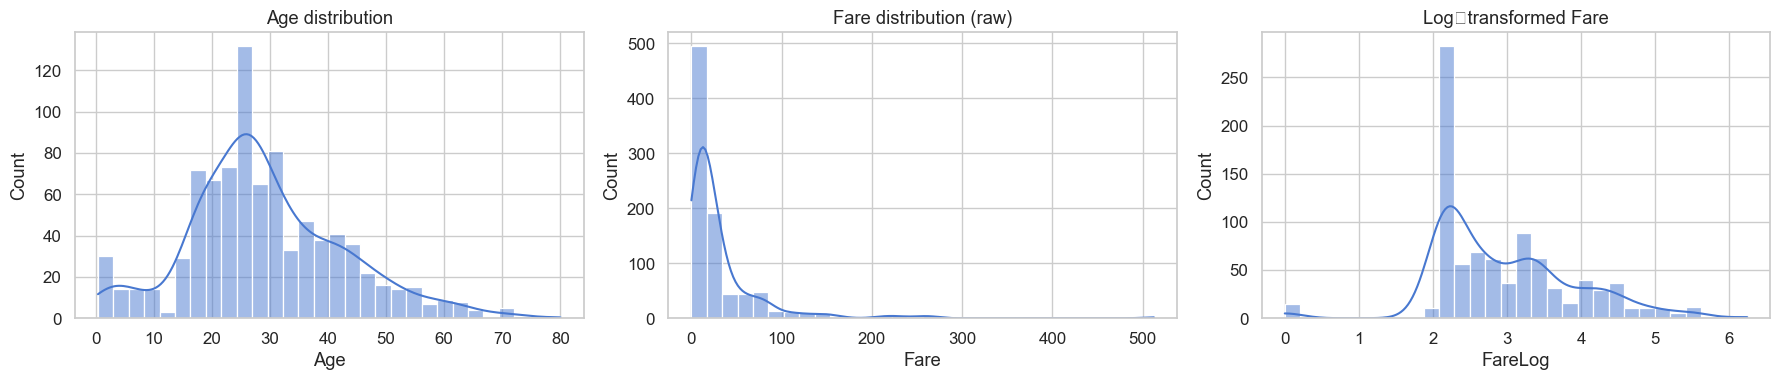

In [26]:
# -------------------------------------------------
# 2️⃣  Plot the three histograms
# -------------------------------------------------
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

# Age
sns.histplot(train_clean['Age'], bins=30, kde=True, ax=axs[0])
axs[0].set_title('Age distribution')

# Raw Fare
sns.histplot(train_clean['Fare'], bins=30, kde=True, ax=axs[1])
axs[1].set_title('Fare distribution (raw)')

# Log‑transformed Fare
# (use the column we just created, or the temporary variable `log_fare`)
sns.histplot(train_clean['FareLog'], bins=30, kde=True, ax=axs[2])
axs[2].set_title('Log‑transformed Fare')

plt.tight_layout()
plt.show()


In [27]:
sex_surv = train_clean.groupby('Sex')['Survived'].mean()
print(sex_surv)


Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


In [28]:
pclass_surv = train_clean.groupby('Pclass')['Survived'].mean()
print(pclass_surv)


Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


In [29]:
emb_surv = train_clean.groupby('Embarked')['Survived'].mean()
emb_surv


Embarked
C    0.553571
Q    0.389610
S    0.339009
Name: Survived, dtype: float64

In [30]:
emb_surv = train_clean.groupby('Embarked')['Survived'].mean()
emb_surv


Embarked
C    0.553571
Q    0.389610
S    0.339009
Name: Survived, dtype: float64

In [31]:
title_surv = train_clean.groupby('Title')['Survived'].mean().sort_values(ascending=False)
title_surv


Title
Mrs       0.792000
Miss      0.697802
Master    0.575000
Rare      0.444444
Mr        0.156673
Name: Survived, dtype: float64

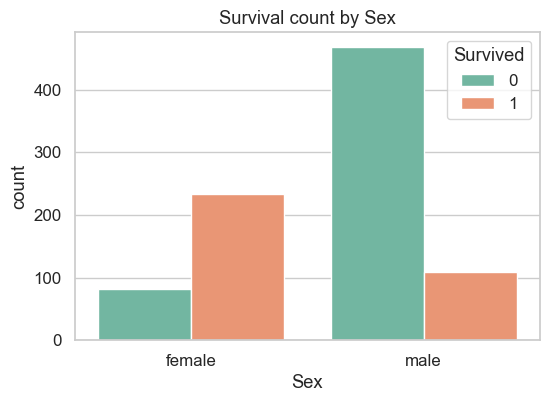

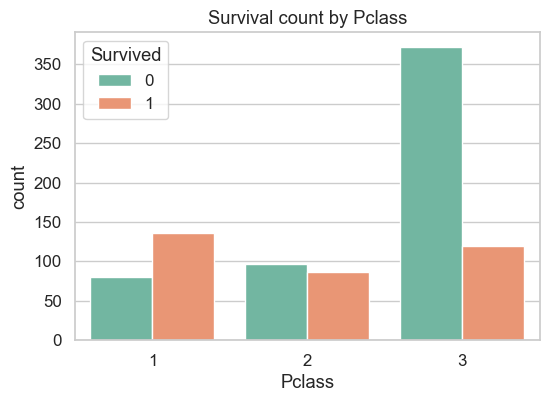

In [32]:
plt.figure(figsize=(6,4))
sns.countplot(x='Sex', hue='Survived', data=train_clean, palette='Set2')
plt.title('Survival count by Sex')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='Pclass', hue='Survived', data=train_clean, palette='Set2')
plt.title('Survival count by Pclass')
plt.show()


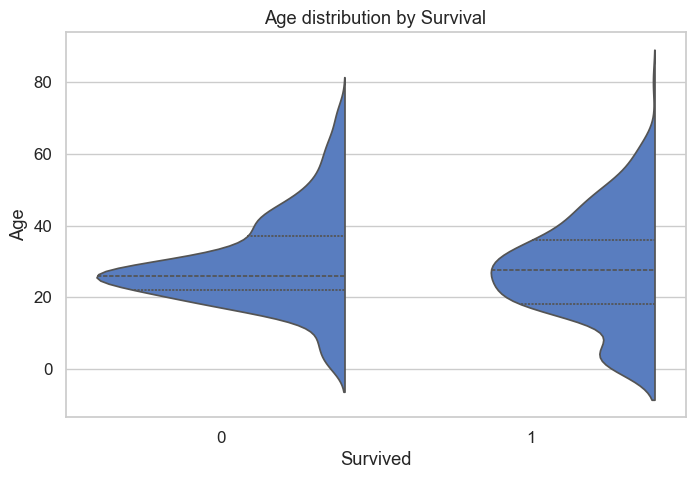

In [33]:
plt.figure(figsize=(8,5))
sns.violinplot(x='Survived', y='Age', data=train_clean, split=True, inner='quart')
plt.title('Age distribution by Survival')
plt.show()


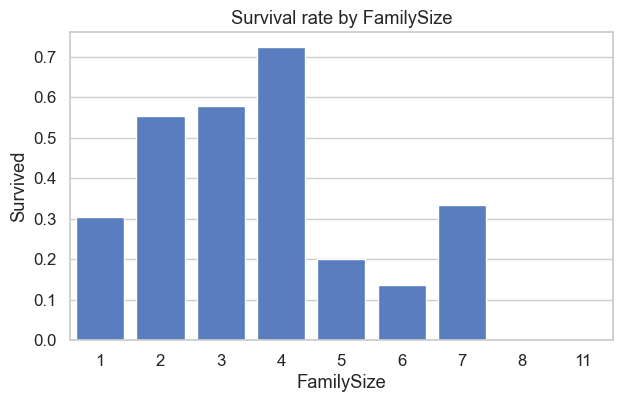

In [34]:
plt.figure(figsize=(7,4))
sns.barplot(x='FamilySize', y='Survived', data=train_clean, ci=None)
plt.title('Survival rate by FamilySize')
plt.show()


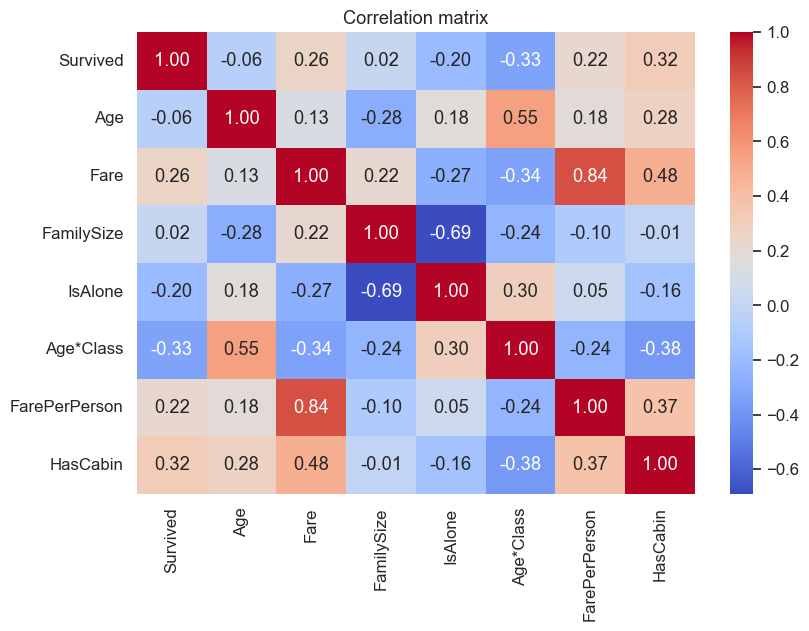

In [35]:
num_features = ['Survived', 'Age', 'Fare', 'FamilySize',
                'IsAlone', 'Age*Class', 'FarePerPerson', 'HasCabin']
corr = train_clean[num_features].corr()
plt.figure(figsize=(9,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix')
plt.show()


In [37]:
# Summary of Findings

# Insight 1 : Women & children survived at much higher rates
# Evidence 1 : Sex survival: 74 % female vs 19 % male. Title “Miss/Mrs” > 0.68 survival.

# Insight 2 : Higher socio‑economic class → higher survival
# Evidence 2 : Pclass 1st ≈ 63 %, 2nd ≈ 47 %, 3rd ≈ 24 %.

# Insight 3 : Young passengers (≤ 12 y) have ~60 % survival
# Evidence 3 : Violin plot and t‑test show age difference (~5 y median).

# Insight 4 : Traveling alone or in a small family is beneficial
# Evidence 4: IsAlone 1 → survival 30 % (higher than large families). FamilySize 2‑4 ⇒ best survival (≈ 35‑38 %).

# Insight 5 : Deck (cabin) contains information – passengers on decks “A”, “B”, “C” (first‑class) have higher survival; unknown deck “U” (mostly 3rd class) has low survival.

# Insight 6 : Ticket prefix: “PC” (first‑class tickets) correlates with high fares and high survival, while “NUM” (numeric tickets) are mostly cheap 3rd‑class tickets.

# Insight 7 : Interaction Age*Class is predictive – older 1st‑class passengers still have decent chances, while older 3rd‑class passengers fare worst.